<a href="https://colab.research.google.com/github/tmajjati/my-project/blob/master/pfanvv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not 

In [2]:
#!pip install pyLDAvis
#!pip install gensim
#!pip install openpyxl --upgrade

In [3]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
#!pip install -U pandas-profiling

clean=pd.read_excel('cleandataanv.xlsx',index_col=0)
clean

,job_id,title,description,requirements,location,department,salary_range,company_profile,employment_type,required_experience,required_education,industry,function,job-des
0,2,Customer Service - Cloud Video Production,Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,Organised - Focused - Vibrant - Awesome!Do you...
1,3,Commissioning Machinery Assistant (CMA),"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,NaN,NaN,NaN,NaN,NaN,"Our client, located in Houston, is actively se..."
2,5,Bill Review Manager,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,JOB TITLE: Itemization Review ManagerLOCATION:...
3,7,Head of Content (m/f),Your Responsibilities: Manage the English-spea...,Your Know-How: ...,"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Full-time,Mid-Senior level,Master's Degree,Online Media,Management,Your Responsibilities: Manage the English-spea...
4,8,Lead Guest Service Specialist,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...","US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,NaN,NaN,NaN,NaN,NaN,Who is Airenvy?Hey there! We are seasoned entr...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056,17876,Account Director - Distribution,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Full-time,Mid-Senior level,NaN,Computer Software,Sales,Just in case this is the first time you’ve vis...
11057,17877,Payroll Accountant,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,The Payroll Accountant will focus primarily on...
11058,17878,Project Cost Control Staff Engineer - Cost Con...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Full-time,NaN,NaN,NaN,NaN,Experienced Project Cost Control Staff Enginee...
11059,17879,Graphic Designer,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,"NG, LA, Lagos",NaN,NaN,NaN,Contract,Not Applicable,Professional,Graphic Design,Design,Nemsia Studios is looking for an experienced v...


In [6]:
data = clean.values.tolist()


In [7]:
data[:1]

[[2,
  'Customer Service - Cloud Video Production',
  "Organised - Focused - Vibrant - Awesome!Do you have a passion for customer service? Slick typing skills? Maybe Account Management? ...And think administration is cooler than a polar bear on a jetski? Then we need to hear you!\xa0We are the Cloud Video Production Service and opperating on a glodal level. Yeah, it's pretty cool. Serious about\xa0delivering a world class product and excellent customer service.Our rapidly expanding business is looking for a talented Project Manager to manage the successful delivery of video projects, manage client communications and drive the production process. Work with some of the coolest brands on the planet and learn from a global team that are representing NZ is a huge way!We are entering the next growth stage of our business and growing quickly internationally. \xa0Therefore, the position is bursting with opportunity for the right person entering the business at the right time.\xa090 Seconds, th

In [8]:
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]

pprint(data[:1])

['[2, Customer Service - Cloud Video Production, "Organised - Focused - '
 'Vibrant - Awesome!Do you have a passion for customer service? Slick typing '
 'skills? Maybe Account Management? ...And think administration is cooler than '
 'a polar bear on a jetski? Then we need to hear you!\\xa0We are the Cloud '
 'Video Production Service and opperating on a glodal level. Yeah, its pretty '
 'cool. Serious about\\xa0delivering a world class product and excellent '
 'customer service.Our rapidly expanding business is looking for a talented '
 'Project Manager to manage the successful delivery of video projects, manage '
 'client communications and drive the production process. Work with some of '
 'the coolest brands on the planet and learn from a global team that are '
 'representing NZ is a huge way!We are entering the next growth stage of our '
 'business and growing quickly internationally. \\xa0Therefore, the position '
 'is bursting with opportunity for the right person entering the 

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['customer', 'service', 'cloud', 'video', 'production', 'organised', 'focused', 'vibrant', 'awesome', 'do', 'you', 'have', 'passion', 'for', 'customer', 'service', 'slick', 'typing', 'skills', 'maybe', 'account', 'management', 'and', 'think', 'administration', 'is', 'cooler', 'than', 'polar', 'bear', 'on', 'jetski', 'then', 'we', 'need', 'to', 'hear', 'you', 'xa', 'we', 'are', 'the', 'cloud', 'video', 'production', 'service', 'and', 'opperating', 'on', 'glodal', 'level', 'yeah', 'its', 'pretty', 'cool', 'serious', 'about', 'xa', 'delivering', 'world', 'class', 'product', 'and', 'excellent', 'customer', 'service', 'our', 'rapidly', 'expanding', 'business', 'is', 'looking', 'for', 'talented', 'project', 'manager', 'to', 'manage', 'the', 'successful', 'delivery', 'of', 'video', 'projects', 'manage', 'client', 'communications', 'and', 'drive', 'the', 'production', 'process', 'work', 'with', 'some', 'of', 'the', 'coolest', 'brands', 'on', 'the', 'planet', 'and', 'learn', 'from', 'global', 

In [10]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [11]:
print(trigram_mod[bigram_mod[data_words[0]]])

['customer', 'service', 'cloud', 'video', 'production', 'organised', 'focused', 'vibrant', 'awesome', 'do', 'you', 'have', 'passion', 'for', 'customer', 'service', 'slick', 'typing', 'skills', 'maybe', 'account', 'management', 'and', 'think', 'administration', 'is', 'cooler', 'than', 'polar', 'bear', 'on', 'jetski', 'then', 'we', 'need', 'to', 'hear', 'you', 'xa', 'we', 'are', 'the', 'cloud', 'video', 'production', 'service', 'and', 'opperating', 'on', 'glodal', 'level', 'yeah', 'its', 'pretty_cool', 'serious', 'about', 'xa', 'delivering', 'world', 'class', 'product', 'and', 'excellent', 'customer', 'service', 'our', 'rapidly_expanding', 'business', 'is', 'looking', 'for', 'talented', 'project', 'manager', 'to', 'manage', 'the', 'successful', 'delivery', 'of', 'video', 'projects', 'manage', 'client', 'communications', 'and', 'drive', 'the', 'production', 'process', 'work', 'with', 'some', 'of', 'the', 'coolest', 'brands', 'on', 'the', 'planet', 'and', 'learn', 'from', 'global', 'team',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['customer', 'service', 'cloud', 'video', 'production', 'organise', 'focus', 'vibrant', 'awesome', 'passion', 'customer', 'service', 'slick', 'typing', 'skill', 'maybe', 'account', 'management', 'nee', 'hear', 'service', 'opperate', 'glodal', 'level', 'serious', 'deliver', 'world', 'class', 'product', 'excellent', 'customer', 'service', 'rapidly_expanding', 'business', 'look', 'talented', 'project', 'manager', 'manage', 'successful', 'delivery', 'video', 'project', 'manage', 'client', 'communication', 'drive', 'production', 'process', 'work', 'cool', 'brand', 'planet', 'learn', 'global', 'team', 'represent', 'huge', 'way', 'enter', 'next', 'growth', 'stage', 'business', 'grow', 'quickly', 'internationally', 'therefore', 'position', 'burst', 'opportunity', 'right', 'person', 'enter', 'business', 'right', 'time', 'second', 'world', 'cloud', 'video', 'production', 'eef_ca', 'second', 'world', 'cloud', 'video', 'production', 'service', 'enable', 'brand', 'agency', 'get', 'high', 'quality'

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 3), (5, 3), (6, 3), (7, 1), (8, 2), (9, 2), (10, 2), (11, 1), (12, 3), (13, 2), (14, 8), (15, 2), (16, 2), (17, 6), (18, 1), (19, 2), (20, 2), (21, 2), (22, 2), (23, 6), (24, 10), (25, 2), (26, 2), (27, 4), (28, 2), (29, 3), (30, 2), (31, 2), (32, 3), (33, 2), (34, 3), (35, 9), (36, 10), (37, 2), (38, 3), (39, 4), (40, 2), (41, 2), (42, 2), (43, 2), (44, 2), (45, 3), (46, 2), (47, 3), (48, 4), (49, 3), (50, 6), (51, 2), (52, 9), (53, 5), (54, 3), (55, 1), (56, 2), (57, 4), (58, 1), (59, 5), (60, 6), (61, 2), (62, 2), (63, 2), (64, 4), (65, 2), (66, 5), (67, 2), (68, 2), (69, 1), (70, 2), (71, 3), (72, 2), (73, 2), (74, 3), (75, 2), (76, 2), (77, 2), (78, 2), (79, 2), (80, 10), (81, 2), (82, 2), (83, 3), (84, 4), (85, 2), (86, 2), (87, 3), (88, 2), (89, 2), (90, 2), (91, 2), (92, 4), (93, 1), (94, 10), (95, 8), (96, 2), (97, 2), (98, 2), (99, 2), (100, 2), (101, 3), (102, 2), (103, 1), (104, 10), (105, 2), (106, 2), (107, 2), (108, 2), (109, 4), (11

In [15]:
id2word[3]


'achieve'

In [16]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 2),
  ('able', 2),
  ('account', 2),
  ('achieve', 2),
  ('ad', 3),
  ('affordable', 3),
  ('agency', 3),
  ('applicable', 1),
  ('attention', 2),
  ('awesome', 2),
  ('base', 2),
  ('bcba', 1),
  ('beautiful', 3),
  ('bogge', 2),
  ('brand', 8),
  ('budgetattitude', 2),
  ('burst', 2),
  ('business', 6),
  ('ca', 1),
  ('campaign', 2),
  ('challengesense', 2),
  ('class', 2),
  ('clear', 2),
  ('client', 6),
  ('cloud', 10),
  ('commissioning', 2),
  ('communicate', 2),
  ('communication', 4),
  ('community', 2),
  ('company', 3),
  ('computer', 2),
  ('constantly_evolve', 2),
  ('content', 3),
  ('cool', 2),
  ('cost', 3),
  ('country', 9),
  ('customer', 10),
  ('deadline', 2),
  ('dedicated', 3),
  ('deliver', 4),
  ('delivery', 2),
  ('detailmotivate', 2),
  ('dosent', 2),
  ('drive', 2),
  ('easy', 2),
  ('eef_ca', 3),
  ('effectively', 2),
  ('enable', 3),
  ('enter', 4),
  ('every_aspect', 3),
  ('excellent', 6),
  ('expect', 2),
  ('experience', 9),
  ('fast', 5)

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [18]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"customer" + 0.029*"service" + 0.020*"work" + 0.017*"skill" + '
  '0.013*"support" + 0.012*"office" + 0.012*"high" + 0.011*"communication" + '
  '0.011*"ability" + 0.011*"time"'),
 (1,
  '0.038*"experience" + 0.028*"system" + 0.024*"technology" + '
  '0.022*"technical" + 0.021*"service" + 0.018*"software" + '
  '0.015*"application" + 0.013*"year" + 0.013*"support" + 0.013*"solution"'),
 (2,
  '0.057*"sale" + 0.031*"customer" + 0.024*"service" + 0.016*"business" + '
  '0.016*"company" + 0.014*"experience" + 0.012*"client" + 0.011*"product" + '
  '0.011*"skill" + 0.010*"position"'),
 (3,
  '0.054*"design" + 0.024*"product" + 0.022*"user" + 0.021*"experience" + '
  '0.019*"work" + 0.017*"designer" + 0.017*"create" + 0.016*"creative" + '
  '0.011*"web" + 0.010*"game"'),
 (4,
  '0.062*"marketing" + 0.030*"medium" + 0.025*"social" + 0.018*"content" + '
  '0.017*"campaign" + 0.014*"brand" + 0.013*"online" + 0.013*"experience" + '
  '0.012*"advertising" + 0.012*"digital"'),
 (5,


In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.29841965330482

Coherence Score:  0.42057966081522447


In [20]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.105500  0.085615       1        1  15.648903
8      0.027068 -0.117123       2        1  15.182851
2      0.076097 -0.028703       3        1   9.178879
1      0.013845 -0.175053       4        1   8.701508
12    -0.153072 -0.141976       5        1   7.368452
4     -0.135129 -0.044922       6        1   7.357327
0      0.175982 -0.037237       7        1   7.152411
11     0.169549 -0.055418       8        1   6.244242
3     -0.171649 -0.030538       9        1   6.204715
5      0.210997  0.103083      10        1   4.429953
13     0.091489  0.177539      11        1   4.273755
7     -0.180883 -0.084244      12        1   4.249685
6      0.125439 -0.011803      13        1   3.019726
10    -0.144232  0.360781      14        1   0.987593, topic_info=            Term          Freq         Total Category  logprob  loglift
748         sale  19502.000000  19502.000000  Default  30.0000  30.0000
490    marketing  17161.000000  17161.000000  Default  29.0000  29.0000
121      product  24229.000000  24229.000000  Default  28.0000  28.0000
36      customer  30865.000000  30865.000000  Default  27.0000  27.0000
667       design  19006.000000  19006.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
160         time    240.532394  23743.267247  Topic14  -5.0290   0.0255
611     pressure    152.865525   1274.307560  Topic14  -5.4823   2.4971
378        offer    163.642112   5304.302524  Topic14  -5.4142   1.1391
1180  innovation    150.249427   1460.211222  Topic14  -5.4996   2.3436
735         move    150.046619   1731.247973  Topic14  -5.5010   2.1720

[1013 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.000587  ability
0         2  0.337436  ability
0         3  0.160650  ability
0         4  0.051281  ability
0         5  0.017133  ability
...     ...       ...      ...
452      12  0.001628     year
452      13  0.047205     year
1834      8  0.998463    yeast
2820      1  0.976069    young
2820     11  0.023266    young

[2487 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 3, 2, 13, 5, 1, 12, 4, 6, 14, 8, 7, 11])

In [21]:
#import os
#os.environ.update({'MALLET_HOME': r'C:/Users/pc/Downloads/mallet-2.0.8/'})

In [22]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

In [23]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [24]:

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-11-08 21:18:04--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  13.3MB/s    in 1.2s    

2021-11-08 21:18:05 (13.3 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [25]:
import zipfile
from google.colab import files

uploaded = files.upload()

Saving mallet-2.0.8.zip to mallet-2.0.8 (1).zip


In [26]:
path_to_zip_file = list(uploaded.keys())[0]

print ('Extracting',path_to_zip_file)

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall('.')

print()
print('Here is a directory listing (you should see a directory with your corpus):')
!ls -l

Extracting mallet-2.0.8.zip

Here is a directory listing (you should see a directory with your corpus):
total 49864
-rw-r--r--  1 root root 18677092 Nov  8 20:52  cleandataanv.xlsx
drwxr-xr-x 10 root root     4096 Nov 14  2016  mallet-2.0.8
-rw-r--r--  1 root root 16184794 Nov  8 21:21 'mallet-2.0.8 (1).zip'
-rw-r--r--  1 root root 16184794 Nov 14  2016  mallet-2.0.8.zip
drwxr-xr-x  1 root root     4096 Nov  1 13:35  sample_data


In [27]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this

In [28]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=14, id2word=id2word)


In [29]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('financial', 0.020205425291948628),
   ('company', 0.01644734104094356),
   ('include', 0.015519264863785052),
   ('report', 0.015140543195079115),
   ('office', 0.014045995954753166),
   ('management', 0.01375050981763095),
   ('maintain', 0.012589374152038021),
   ('finance', 0.011911004569630684),
   ('employee', 0.011166046561956368),
   ('information', 0.010108955310843092)]),
 (2,
  [('skill', 0.0893676848758682),
   ('ability', 0.05511227538913857),
   ('work', 0.04843503408717665),
   ('experience', 0.045695242215225876),
   ('strong', 0.036138015012777684),
   ('communication', 0.033958999254968876),
   ('excellent', 0.02455798825574595),
   ('environment', 0.022663366098680575),
   ('write', 0.020356172943353602),
   ('knowledge', 0.0148445448500725)]),
 (0,
  [('design', 0.060459800238781634),
   ('web', 0.04394892402667366),
   ('experience', 0.03770638595265135),
   ('user', 0.024908272909932732),
   ('work', 0.024198479951078884),
   ('developer', 0.0238708832008

In [30]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [31]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

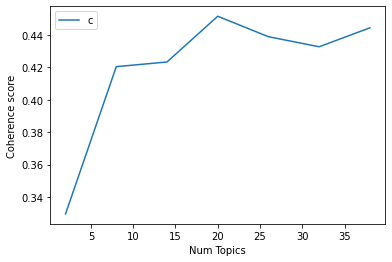

In [32]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3296
Num Topics = 8  has Coherence Value of 0.4205
Num Topics = 14  has Coherence Value of 0.4234
Num Topics = 20  has Coherence Value of 0.4516
Num Topics = 26  has Coherence Value of 0.439
Num Topics = 32  has Coherence Value of 0.4328
Num Topics = 38  has Coherence Value of 0.4444


In [34]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.074*"design" + 0.058*"web" + 0.036*"experience" + 0.034*"developer" + '
  '0.031*"user" + 0.020*"mobile" + 0.020*"end" + 0.019*"designer" + '
  '0.019*"development" + 0.018*"work"'),
 (1,
  '0.051*"team" + 0.035*"work" + 0.023*"role" + 0.022*"people" + 0.021*"grow" '
  '+ 0.014*"deliver" + 0.014*"join" + 0.013*"part" + 0.013*"world" + '
  '0.011*"brand"'),
 (2,
  '0.047*"candidate" + 0.028*"experience" + 0.027*"company" + 0.017*"job" + '
  '0.017*"service" + 0.017*"industry" + 0.014*"year" + 0.014*"hire" + '
  '0.013*"position" + 0.012*"recruitment"'),
 (3,
  '0.106*"experience" + 0.050*"year" + 0.035*"degree" + 0.023*"language" + '
  '0.022*"skill" + 0.021*"company" + 0.021*"team" + 0.020*"work" + '
  '0.020*"knowledge" + 0.019*"full"'),
 (4,
  '0.048*"system" + 0.037*"technology" + 0.032*"application" + '
  '0.027*"experience" + 0.027*"technical" + 0.025*"software" + 0.022*"support" '
  '+ 0.017*"server" + 0.016*"development" + 0.015*"information"'),
 (5,
  '0.103*"project"

In [35]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4835,"team, work, role, people, grow, deliver, join,...","[2, Customer Service - Cloud Video Production,..."
1,1,11.0,0.4300,"job, require, equipment, perform, work, engine...","[3, Commissioning Machinery Assistant (CMA), O..."
2,2,8.0,0.3115,"financial, report, management, ensure, process...","[5, Bill Review Manager, JOB TITLE: Itemizatio..."
3,3,19.0,0.1840,"marketing, medium, social, content, campaign, ...","[7, Head of Content (m/f), Your Responsibiliti..."
4,4,14.0,0.2257,"work, team, make, people, love, great, company...","[8, Lead Guest Service Specialist , Who is Air..."
5,5,4.0,0.2103,"system, technology, application, experience, t...","[9, HP BSM SME, Implementation/Configuration/T..."
6,6,6.0,0.2210,"skill, ability, work, strong, communication, e...","[11, ASP.net Developer Job opportunity at Unit..."
7,7,14.0,0.2882,"work, team, make, people, love, great, company...","[12, Talent Sourcer (6 months fixed-term contr..."
8,8,4.0,0.2945,"system, technology, application, experience, t...","[13, Applications Developer, Digital , The App..."
9,9,12.0,0.2578,"sale, business, market, client, account, lead,...","[16, VP of Sales - Vault Dragon, ""About Vault ..."


In [36]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5764,"design, web, experience, developer, user, mobi...","[11375, Senior Visual Designer, Ixonos is a gl..."
1,1.0,0.5679,"team, work, role, people, grow, deliver, join,...","[4816, Blip Builder / Mobile Augmented Reality..."
2,2.0,0.5578,"candidate, experience, company, job, service, ...","[6952, Drilling Engineer, This is a fantastic\..."
3,3.0,0.5620,"experience, year, degree, language, skill, com...","[3220, Programmer-Computational Linguist, We c..."
4,4.0,0.6050,"system, technology, application, experience, t...","[5964, Application Developer/SQL Server, Title..."
5,5.0,0.6218,"project, client, management, team, business, s...","[16699, Project Coordinator, We are looking fo..."
6,6.0,0.7082,"skill, ability, work, strong, communication, e...","[4193, Sales Executive, &Eta; &epsilon;&tau;&a..."
7,7.0,0.7257,"customer, service, provide, support, company, ...","[10267, Contact Center Representatives, Tidewa..."
8,8.0,0.6541,"financial, report, management, ensure, process...","[1049, Senior Auditor, Performing individual i..."
9,9.0,0.5701,"office, support, maintain, event, include, mem...","[5601, Office Assistant, General PurposeProvid..."


In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics['Dominant_Topic']


0.0         1.0
1.0        11.0
2.0         8.0
3.0        19.0
4.0        14.0
           ... 
11056.0    14.0
11057.0     8.0
11058.0    11.0
11059.0     0.0
11060.0    14.0
Name: Dominant_Topic, Length: 11061, dtype: float64

In [39]:
from gensim.models.ldamodel import LdaModel
import numpy

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha, eta=0, iterations=1000, gamma_threshold=0.001, dtype=numpy.float32)
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

converted_model = ldaMalletConvertToldaGen(optimal_model)

In [40]:
pyLDAvis.enable_notebook()
viss = pyLDAvis.gensim_models.prepare(converted_model, corpus, id2word)
viss

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14     0.211567 -0.209862       1        1  6.345174
10     0.006247  0.133666       2        1  6.147535
0      0.240838  0.081977       3        1  5.790727
19     0.106965  0.062490       4        1  5.744542
1      0.213242 -0.167597       5        1  5.543656
5     -0.025955  0.170107       6        1  5.520827
4     -0.001476  0.225603       7        1  5.519407
6      0.016049 -0.113134       8        1  5.213760
12     0.040259  0.061052       9        1  5.207936
11    -0.188905  0.069221      10        1  5.119967
17     0.199481  0.154521      11        1  5.084397
8     -0.229765  0.160438      12        1  4.720778
16     0.133380  0.084428      13        1  4.523265
9     -0.176597 -0.078347      14        1  4.421471
2     -0.108177 -0.150876      15        1  4.338700
7     -0.165190 -0.090863      16        1  4.294107
18    -0.173250 -0.087416      17        1  4.247921
15    -0.143272 -0.007906      18        1  4.220922
3      0.059202 -0.013054      19        1  4.032734
13    -0.014642 -0.284445      20        1  3.962173, topic_info=           Term          Freq         Total Category  logprob  loglift
36     customer  31367.000000  31367.000000  Default  30.0000  30.0000
121     product  25979.000000  25979.000000  Default  29.0000  29.0000
124     project  21201.000000  21201.000000  Default  28.0000  28.0000
748        sale  20083.000000  20083.000000  Default  27.0000  27.0000
142     service  28847.000000  28847.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
43        drive   1214.557465  10499.570481  Topic20  -4.7990   1.0714
1584  education   1006.818687   3530.972567  Topic20  -4.9866   1.9736
443    training   1048.586323   5366.683274  Topic20  -4.9460   1.5956
208      ensure   1059.577813  11411.412484  Topic20  -4.9355   0.8516
74         high    995.827265  15028.824798  Topic20  -4.9976   0.5142

[1948 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.053002  ability
0         8  0.772983  ability
0         9  0.024427  ability
0        10  0.068908  ability
0        14  0.043458  ability
...     ...       ...      ...
2820      5  0.904044    young
2820     17  0.020229    young
2820     20  0.075337    young
1942      5  1.006970  zealand
5022      7  0.953229  παροχης

[4093 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 11, 1, 20, 2, 6, 5, 7, 13, 12, 18, 9, 17, 10, 3, 8, 19, 16, 4, 14])